In [ ]:
import kagglehub

path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

print("Path to dataset files:", path)

Path to dataset files: /home/lnxdread/.cache/kagglehub/datasets/alanvourch/tmdb-movies-daily-updates/versions/280


In [8]:
import pandas as pd

# Load CSV from './TMDB_all_movies.csv'
df = pd.read_csv(f"{path}/TMDB_all_movies.csv")

# Leave only the columns ['id', 'title', 'vote_average', 'status', 'release_date', 'budget', 'revenue', 'popularity', 'genres', 'cast', 'director', 'production_companies']
df = df[['id', 'title', 'vote_average', 'status', 'release_date', 'budget', 'revenue', 'popularity', 'genres', 'cast', 'director', 'production_companies']]

# Drop rows with NaN values
df = df.dropna()

# Save the result to './TMDB_all_movies_cleaned.csv'
df.to_csv('./TMDB_all_movies_cleaned.csv', index=False)

             id                                         title  vote_average  \
33573     49797                               I Saw the Devil           7.8   
408276   581389                                Space Sweepers           7.1   
3308       5924                                      Papillon           7.8   
1264       1895  Star Wars: Episode III - Revenge of the Sith           7.4   
778724  1097549                                      Babygirl           0.0   

          status release_date       budget      revenue  popularity  \
33573   Released   2010-08-12    6000000.0   12966357.0      29.992   
408276  Released   2021-02-05   21000000.0      24571.0      29.992   
3308    Released   1973-12-16   12000000.0   53267000.0      29.988   
1264    Released   2005-05-17  113000000.0  850000000.0      29.962   
778724  Released   2024-12-25          0.0          0.0      29.961   

                                    genres  \
33573                     Thriller, Horror   
408276

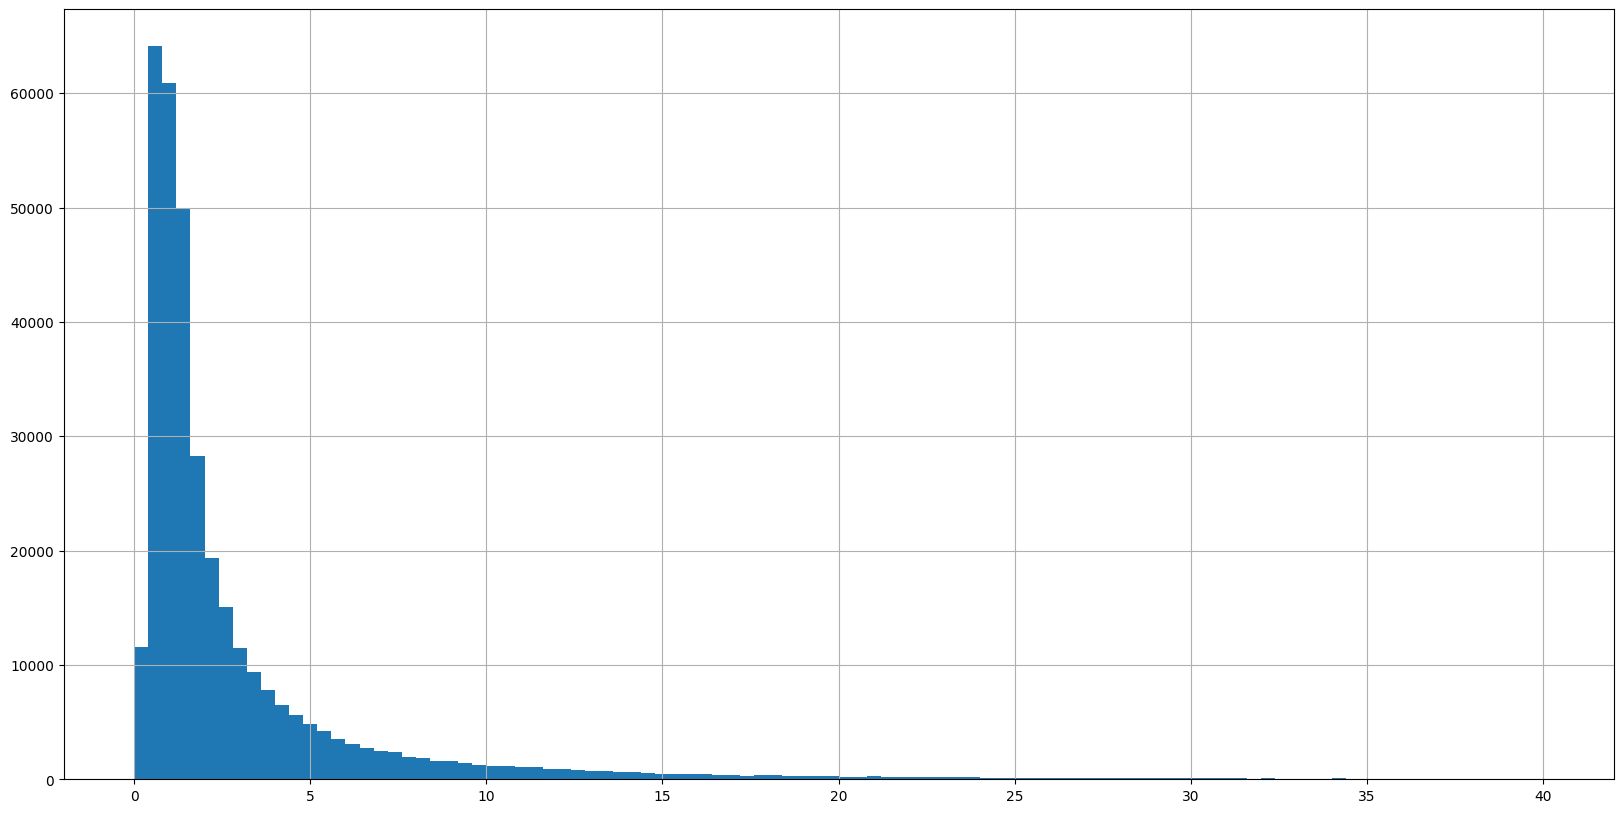

In [9]:
# Print the first 5 rows
#print(df.head())

# Show some examples of movies with a popularity between 0 and 5, sorted by popularity
print(df[(df['popularity'] >= 25) & (df['popularity'] < 30)].sort_values(by='popularity', ascending=False).head())

# Make an histogram of the 'popularity' column, with 100 bins, with an interval of 5 ([0, 5[, [5, 10[, [10, 15[, etc.)])
df['popularity'].hist(bins=100, range=(0, 40), figsize=(20, 10))

# Remove movies with a popularity below 20
df = df[df['popularity'] >= 15]

# Remove movies with a budget of 0
df = df[df['budget'] > 0]

# Save the result to './TMDB_all_movies_cleaned_2.csv'
df.to_csv('./TMDB_all_movies_cleaned_2.csv', index=False)


In [ ]:
# actors
# directors 
# movies 

